In [4]:
from skimage import io ,transform ,feature,measure,filters,exposure
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import os
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2
import glob
from commonfunctions import *

from matplotlib import cm
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin,area_closing

import sys
np.set_printoptions(threshold=sys.maxsize)
from collections import Counter 

from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.util import img_as_ubyte
from Matcher import match

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)
    
    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')


In [6]:
#-------------------------------------------------------BINARIZATION-------------------------------------------------------#

def to_binary(img,val):
    threshold = np.copy(img)
    threshold[threshold<val]=0
    threshold[threshold>=val]=1
    return threshold

#--------------------------------------------------------------------------------------------------------------------------#

def binarize(img):
    
    threshold = filters.threshold_otsu(img)
    img = to_binary(img,threshold)
    return img

In [7]:
def GammaCorrection(img,c,gamma):
    
    outputImg= np.ones(img.shape)
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            outputImg[y][x]=c*(img[y][x]**gamma)
            
    return outputImg

In [8]:
def deskew(img):
    
    #GET HOUGH TRANFROM
    hspace, angles, distances=transform.hough_line(img)
    
    #Find the top (angles,d) pairs that have the highest count in the Hough matrix 
    accum, angles_2, dists = transform.hough_line_peaks(hspace, angles, distances)
  
    
    #Calulate the skew angle as an average of the angles
    skewAngle = np.rad2deg(np.median(angles_2))
   
    #Rotate the image by – skew angle
    if(skewAngle<0):
        rotatedImg=img_as_ubyte(transform.rotate(img, 90-abs(skewAngle),resize=True))
    else:
        rotatedImg=img_as_ubyte(transform.rotate(img,skewAngle-90,resize=True))


    
    return rotatedImg

In [9]:
#-----------------------------------------STAFF DETECTION AND REMOVAL-------------------------------------------------------#

def Run_Length_Encoding(array):
    ones = 0 
    zeros = 0
    output =[]
    output_BW =[]
    for i in range(len(array)):
        
        if array[i] == 0:
            zeros+=1
        elif array[i] == 1:
            ones+=1

        if i+1 < len(array):
            if array[i+1] != array[i]:
                if array[i] == 0:
                    output.append(zeros)
                    output_BW.append(0)
                    zeros=0
                elif array[i] == 1:
                    output.append(ones)
                    output_BW.append(1)
                    ones=0
                    
        if i+1 == len(array):
            if array[i] == 0:
                output.append(zeros)
                output_BW.append(0)
                zeros=0
            elif array[i] == 1:
                output.append(ones)
                output_BW.append(1)
                ones=0           
                
    return output,output_BW

#--------------------------------------------------------------------------------------------------------------------------#
def most_frequent(lst):
    x= Counter(lst).most_common(1)
    zz = [list(elem) for elem in x]
    for i in range(len(zz)):
        if i == 0:
            if zz[i][1] == 1:
                return min(lst)
        return zz[i][0]
    
#--------------------------------------------------------------------------------------------------------------------------#    
def calculate_reference_lengths(img):
    
    staffspaceheight_arr = []
    stafflineheight_arr = []
    for i in range(img.shape[1]):
        col=img[:,i]
        output,output_BW = Run_Length_Encoding(col)
        ones= []
        zeros = []
        for i in range(len(output)):
            if output_BW[i] ==1:
                ones.append(output[i])
            else:
                zeros.append(output[i])
        staffspaceheight_arr.append(most_frequent(ones))
        stafflineheight_arr.append(most_frequent(zeros))
        
    staffspaceheight = most_frequent(staffspaceheight_arr)
    stafflineheight = most_frequent(stafflineheight_arr )

    return  staffspaceheight , stafflineheight  

In [10]:
def staffline_detection_removal(img, stafflineheight, staffspaceheight):
    #we want to detect where are the positions of the staff lines 
    
    num_rows = img.shape[0]  # Image Height (number of rows)
    num_cols = img.shape[1]  # Image Width (number of columns)
    
    #GENERATING A HORIZONTAL HISTOGRAM , PEAKS DETECT THE STAFF LINES
    horizontal_histogram = []
    for i in range(img.shape[0]):
        row = img[i]
        num_black_pixels = 0
        for j in range(len(row)):
            if (row[j] == 0):
                num_black_pixels += 1
        horizontal_histogram.append(num_black_pixels)
   
    # we usually have 5 lines per staff
    num_stafflines = 5
    threshold = 0.4
    
    # staff is a set of 5 lines 
    staff_length = num_stafflines * (stafflineheight + staffspaceheight) - staffspaceheight

    current_row = 0
    
    all_staff_row_indices=[]
    
            
    #moving with a window size eof staff lenght of the numbe of rows     
    while (current_row < (num_rows - staff_length + 1)):
        #get all staff lines in this area (staff area)
        staff_lines = [horizontal_histogram[j: j + stafflineheight] for j in
                       range(current_row, current_row + (num_stafflines - 1) * (stafflineheight + staffspaceheight) + 1,
                             stafflineheight + staffspaceheight)]
        #check if their is any line that doessn't pass the threshold therefore this area is not the staff area
        k=0
        for line in staff_lines:
            if (sum(line) / stafflineheight < threshold * num_cols):
                current_row += 1
                k=1
                break
#         else:
                #if all lines passed this the codition then its in fact the staff area
                #append all indices of each staff line of a staff
        if(k!=1):
            staff_row_indices = [list(range(j, j + stafflineheight)) for j in
                                 range(current_row,
                                       current_row + (num_stafflines - 1) * (stafflineheight + staffspaceheight) + 1,
                                       stafflineheight + staffspaceheight)]

            all_staff_row_indices.append(staff_row_indices)
            current_row = current_row + staff_length
  #--------------------------------------------------------------------------------------------------------------------------#   
  #--------------------------------------------------------------------------------------------------------------------------#
  #--------------------------------------------------------------------------------------------------------------------------#
    
   # now we have all the the staff line positions we need to find  and remove lines       

    # Create list of tuples of the form (column index, number of occurrences of width_spacing_sum)
    all_staff_extremes = []

    # Find start of staff for every staff in piece
    for i in range(len(all_staff_row_indices)):
        begin_list = [] # Stores possible beginning column indices for staff
        end_list = []   # Stores possible end column indices for staff
        begin = 0
        end = num_cols - 1

        
        # Find staff beginning
        for j in range(num_cols // 2):
            first_staff_rows_isolated = img[all_staff_row_indices[i][0][0]:all_staff_row_indices[i][4][stafflineheight - 1], j]
            num_black_pixels = len(list(filter(lambda x: x == 0, first_staff_rows_isolated)))
            if (num_black_pixels == 0):
                begin_list.append(j)

        # Find maximum column that has no black pixels in staff window
        list.sort(begin_list, reverse=True)
        begin = begin_list[0]

        # Find staff beginning
        for j in range(num_cols // 2, num_cols):
            first_staff_rows_isolated = img[all_staff_row_indices[i][0][0]:all_staff_row_indices[i][4][stafflineheight - 1], j]
            num_black_pixels = len(list(filter(lambda x: x == 0, first_staff_rows_isolated)))

            if (num_black_pixels == 0):
                end_list.append(j)

        # Find maximum column that has no black pixels in staff window
        list.sort(end_list)
        end = end_list[0]

        staff_extremes = (begin, end)
        all_staff_extremes.append(staff_extremes)   
            
            
  #--------------------------------------------------------------------------------------------------------------------------#   
  #-----------------------------------------------------LINE REMOVAL---------------------------------------------------------#
  #--------------------------------------------------------------------------------------------------------------------------#
              
        
        no_staff_img = np.copy(img)
        for staff in all_staff_row_indices:
            for line in staff:
                for row in line:
                    # Remove top and bottom line to be sure
                    no_staff_img[row - 1, :] = 1
                    no_staff_img[row - 2, :] = 1
             
                    no_staff_img[row, :] = 1
                    no_staff_img[row + 1, :] = 1
                    no_staff_img[row + 2, :] = 1
                   
                   
        return no_staff_img
    

In [11]:
def segmentation(img):
    
    #apply closing 
    closedImage=binary_closing(1-img)
    
    #label the image
    label_image = measure.label(closedImage,connectivity=2,background=0)
    
    # show image after segmentation
    show_images([img,label_image],['img','label_image'])
    
    segmented_notes=[] #list of the segmented notes
    titles=[] #list of strings for image show titles
    i=1 #number of segment for image show titles

    Dict = {} 
    #loop on each labeled segment
    for region in measure.regionprops(label_image):
        
        # take regions with large enough areas
        if region.area >= 100:
            
            # get rectangle around segmented notes
            minr, minc, maxr, maxc = region.bbox
            
            #take this part from original binarized image
            #note.append(img[minr:maxr+2,minc:maxc+2])
            Dict[minc]=img[minr:maxr+2,minc:maxc+2]
            
            
            #add it to the list
           
            titles.append(str(i))
            i+=1
    print(Dict.keys())
    for i in sorted (Dict.keys()) : 
        segmented_notes.append(Dict[i])
         
    return segmented_notes,titles

----------------------- 01.png ------------------------------


<ipython-input-12-07b029eb3e54>:8: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  gray_scale_img = (rgb2gray(img)*255).astype(np.uint8)
<ipython-input-12-07b029eb3e54>:11: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  gaussian = filters.gaussian(rgb2gray(img),sigma =0.6 )


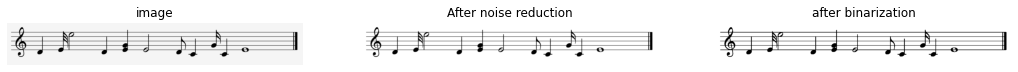

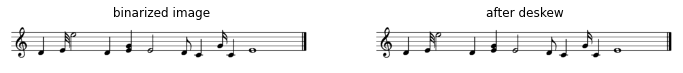

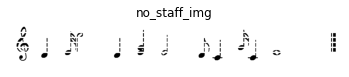

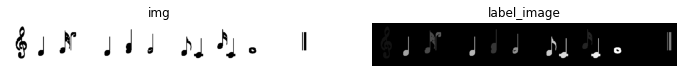

dict_keys([43, 1038, 587, 260, 314, 1456, 1465, 694, 154, 481, 861, 923, 1082, 1194])
14


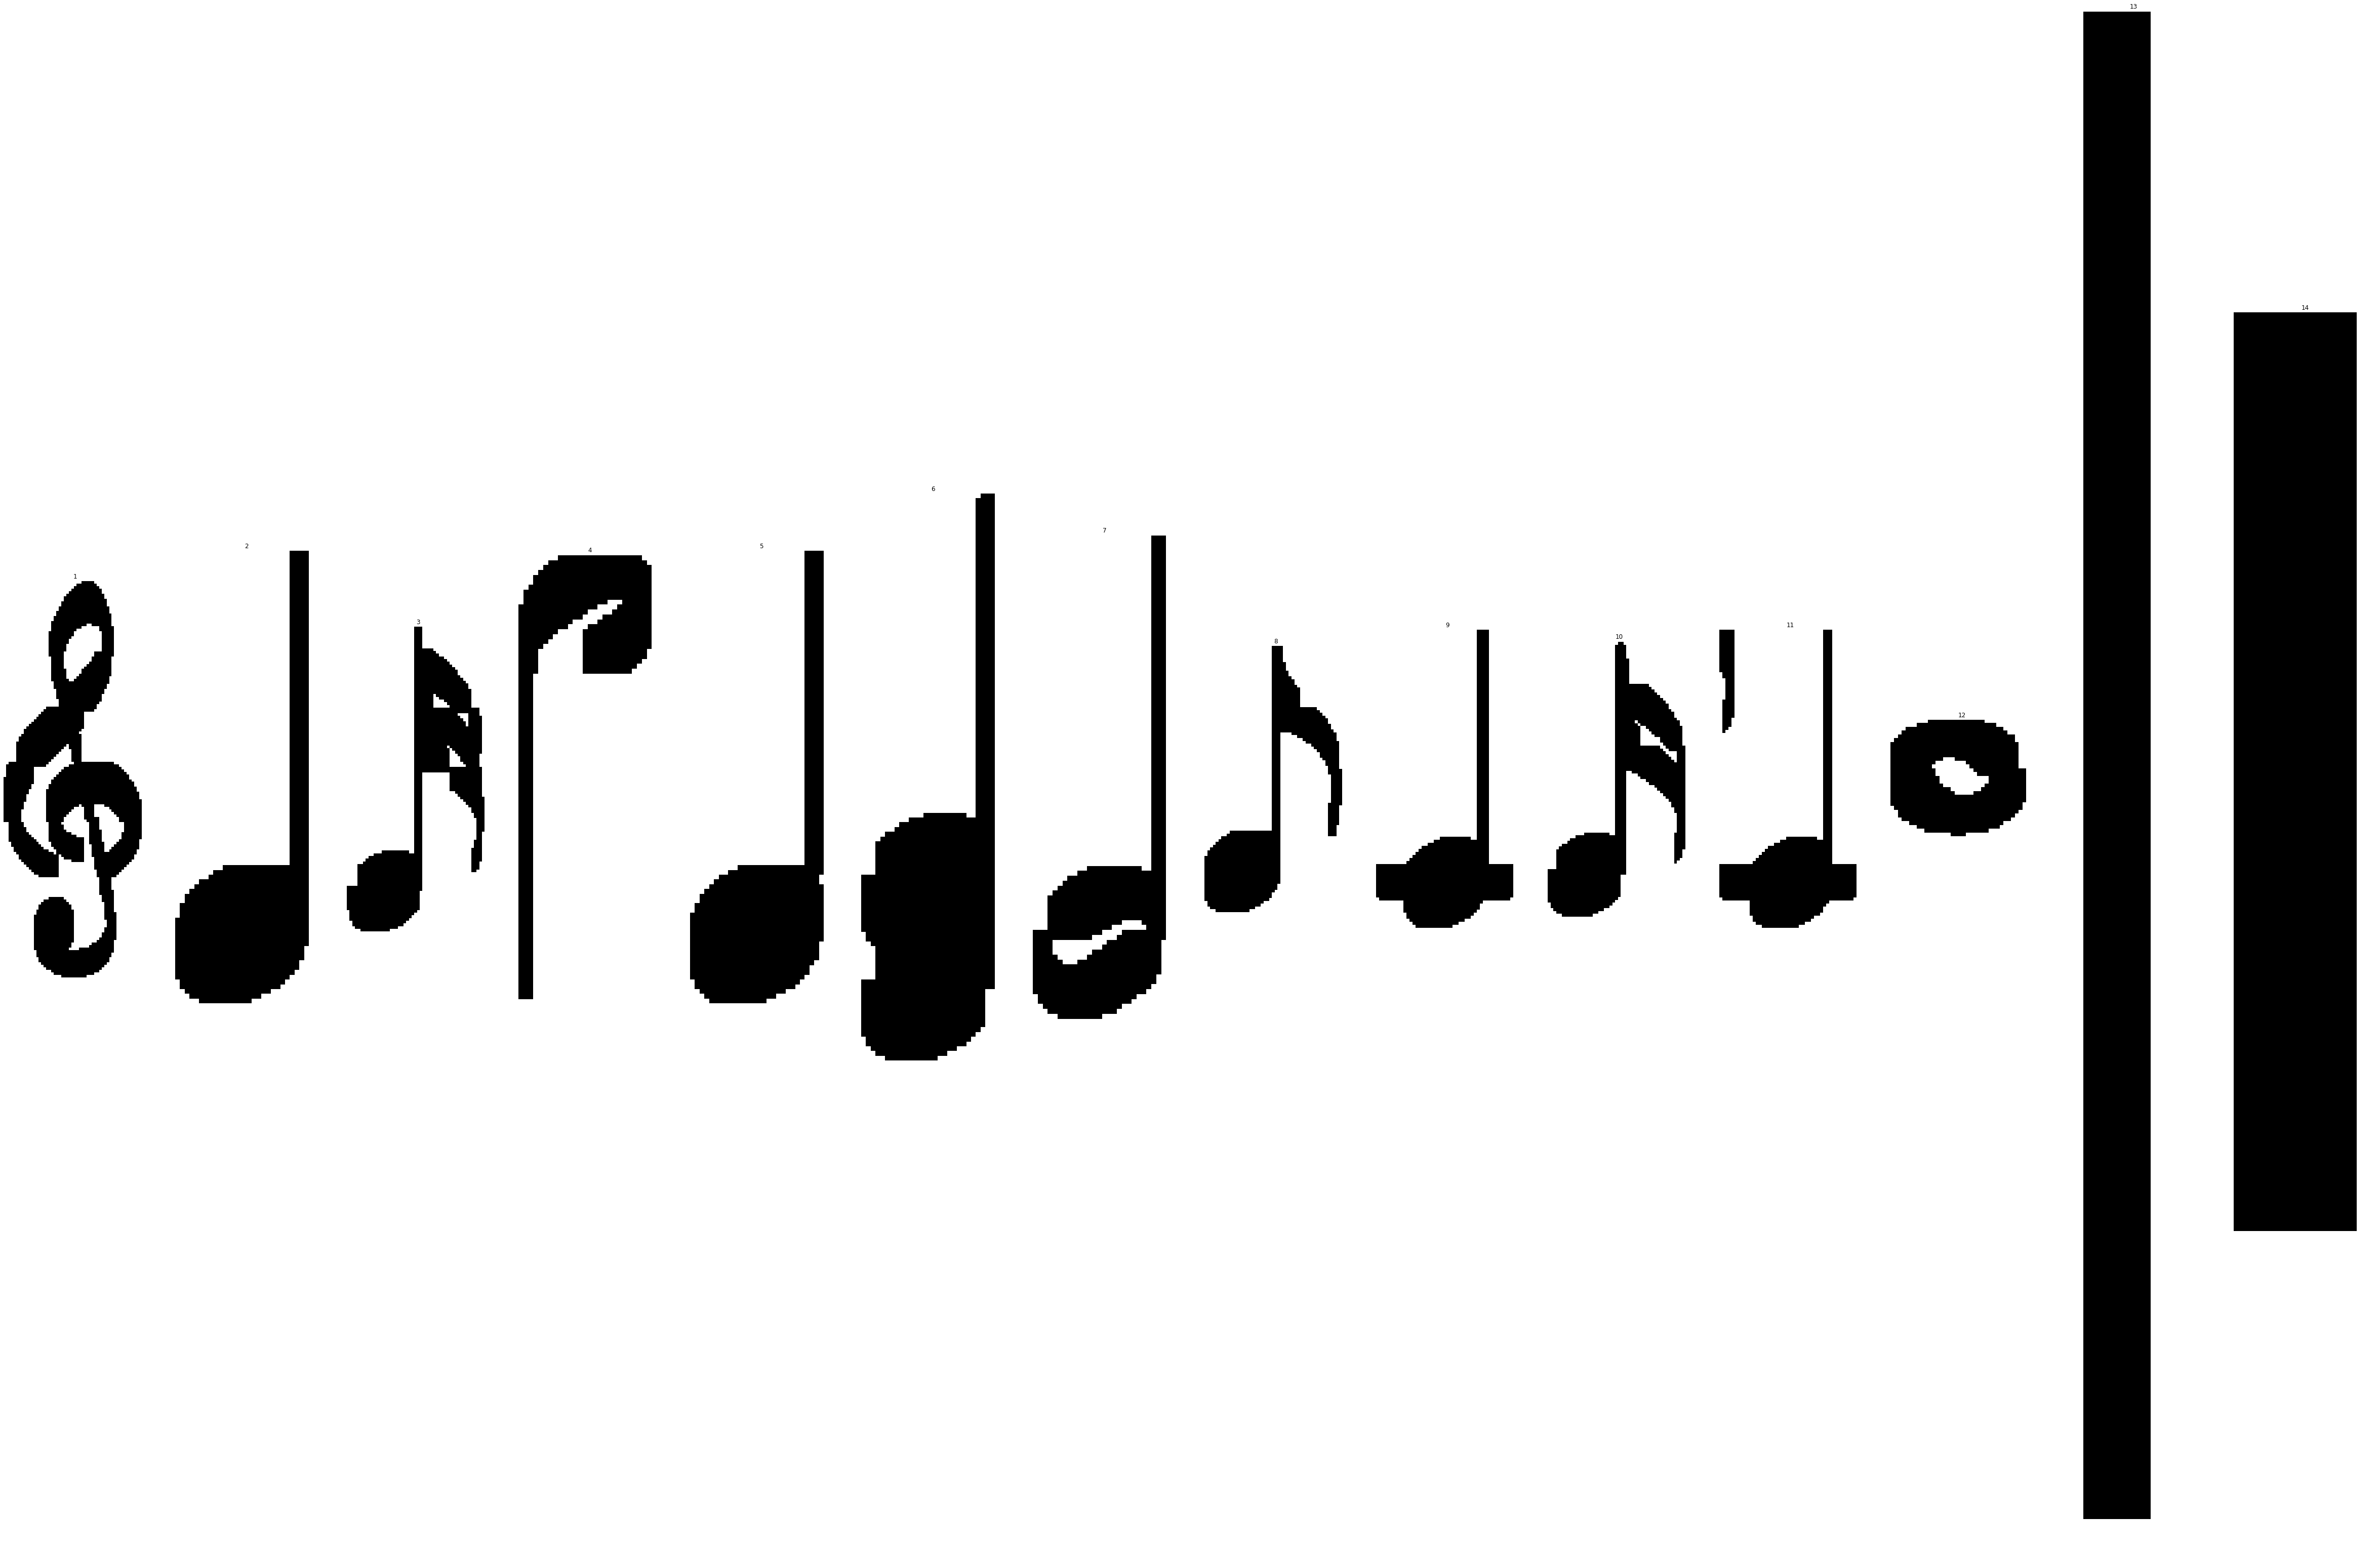

In [12]:
files = glob.glob ("01.png")
for file in files:
    #reading an image
    print("-----------------------",file,"------------------------------")
    img=io.imread(file)
    
    #converting it to a gray image
    gray_scale_img = (rgb2gray(img)*255).astype(np.uint8)

    #applying gaussian filter to remove noise
    gaussian = filters.gaussian(rgb2gray(img),sigma =0.6 )
    
    #binarization process
    gaussianbinarized = binarize(gaussian)
    show_images([img,gaussian,gaussianbinarized],['image','After noise reduction','after binarization'])
    img = gaussianbinarized.astype(np.uint8)  
    
    #deskweing Image 
    deskewImage = deskew(1-img)
    show_images([img,1-deskewImage],[' binarized image','after deskew'])
    deskewImage=1-deskewImage
    deskewImage = deskewImage.astype(np.uint8)  

#     print(deskewImage)
    #staff line detection and removal
    staffspaceheight , stafflineheight  = calculate_reference_lengths(deskewImage)
    #print(stafflineheight, staffspaceheight)
    no_staff_img = staffline_detection_removal(deskewImage, stafflineheight, staffspaceheight)
    
    show_images([no_staff_img],['no_staff_img'])
    
    
    #builtin_dilation = binary_erosion(binary_erosion(no_staff_img))
    SE=np.ones((5,1))
    builtin_morph= binary_dilation(binary_dilation(1-no_staff_img,SE),SE)
    
    
    
    
#     binary_erosion, binary_dilation, binary_closing
#     show_images([no_staff_img,1-builtin_morph],['no_staff_img','builtin_morph'])

   # show_images([no_staff_img,1-builtin_morph],['no_staff_img','builtin_morph'])
    
    segmented_notes,titles=segmentation(1-builtin_morph)
    print(len(segmented_notes))
    show_images(segmented_notes,titles)
    
    

In [13]:
staff_files = [
    "../resources/template/staff2.png", 
    "../resources/template/staff.png"]
quarter_files = [
    "../resources/template/quarter.png", 
    "../resources/template/solid-note.png"]
sharp_files = [
    "../resources/template/sharp.png"]
flat_files = [
    "../resources/template/flat-line.png", 
    "../resources/template/flat-space.png" ]
half_files = [
    "../resources/template/half-space.png", 
    "../resources/template/half-note-line.png",
    "../resources/template/half-line.png", 
    "../resources/template/half-note-space.png"]
whole_files = [
    "../resources/template/whole-space.png", 
    "../resources/template/whole-note-line.png",
    "../resources/template/whole-line.png", 
    "../resources/template/whole-note-space.png"]
time_files = [
    "../resources/template/24.jpg",
    "../resources/template/34.jpg",
    "../resources/template/44.jpg",
    "../resources/template/68.jpg",
    "../resources/template/common.jpg"
]
sharp_files = [
    "../resources/template/f-sharp.png",
     "../resources/template/sharp.png",
     "../resources/template/sharp-line.png",
     "../resources/template/sharp-space.png"
]
clef_files = [
    "../resources/template/treble_1.jpg",
    "../resources/template/treble_2.jpg",
#     "../resources/template/bass_1.jpg"
]
rest_files = [
    "../resources/template/bar-rest.png",
    "../resources/template/eighth_rest.jpg",
    "../resources/template/quarter_rest.jpg",
    "../resources/template/whole_rest.jpg"

    
]

#staff_imgs = [io.imread(staff_file) for staff_file in staff_files]
quarter_imgs = [io.imread(quarter_file) for quarter_file in quarter_files]
sharp_imgs = [io.imread(sharp_files) for sharp_files in sharp_files]
flat_imgs = [io.imread(flat_file) for flat_file in flat_files]
half_imgs = [io.imread(half_file) for half_file in half_files]
whole_imgs = [io.imread(whole_file) for whole_file in whole_files]
rest_imgs = [io.imread(rest_file) for rest_file in rest_files]
clef_imgs = [io.imread(clef_file) for clef_file in clef_files]
time_imgs = [io.imread(time_file) for time_file in time_files]

In [23]:
img = io.imread("download.png")
img = rgb2gray(img)
best_locations, best_scale = match(img, whole_imgs,0.85)
print(best_locations)

<ipython-input-23-3e5fb0d4e163>:2: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img = rgb2gray(img)


TypeError: can't multiply sequence by non-int of type 'float'